<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_10/c)_Build_%26_Train_Transformer_from_Scratch_(Sentiment_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Install TensorFlow

In [2]:
!pip install tensorflow

##  Step 2: Import Libraries and Set Up Environment

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Step 3: Create Synthetic Tokenized Dataset

In [4]:
# Simulated vocabulary and sequence parameters
vocab_size = 2000
sequence_length = 100
num_classes = 2
samples = 1000

# Generate synthetic data
X = np.random.randint(0, vocab_size, size=(samples, sequence_length))
y = np.random.randint(0, num_classes, size=(samples,))

# Train/validation split
X_train, y_train = X[:800], y[:800]
X_val, y_val = X[800:], y[800:]


## Step 4: Define Positional Embedding Layer

In [5]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        embedded_tokens = self.token_emb(x)
        embedded_positions = self.pos_emb(positions)
        return embedded_tokens + embedded_positions


##  Step 5: Define Transformer Encoder Block

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

## Step 6: Build the Transformer Model

In [8]:
# Model hyperparameters
embed_dim = 32
num_heads = 2
ff_dim = 64
inputs = layers.Input(shape=(sequence_length,))

# Embedding + Positional Encoding
x = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)(inputs)

# Transformer Encoder
# Pass training=False during inference
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False) # Add training argument here

# Pooling + Dense Layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Final model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 100, 32)        │        67,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 100, 32)        │        12,736 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,638 (314.99 KB)

 Trainable params: 80,638 (314.99 KB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Compile and Train the Transformer Model

In [9]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=5
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5048 - loss: 0.7134 - val_accuracy: 0.5450 - val_loss: 0.6903
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.4690 - loss: 0.6991 - val_accuracy: 0.5450 - val_loss: 0.6877
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5335 - loss: 0.6878 - val_accuracy: 0.5450 - val_loss: 0.6874
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5973 - loss: 0.6643 - val_accuracy: 0.5450 - val_loss: 0.7111
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7290 - loss: 0.5989 - val_accuracy: 0.5200 - val_loss: 0.7161


## Step 8: Plot Training and Validation Accuracy

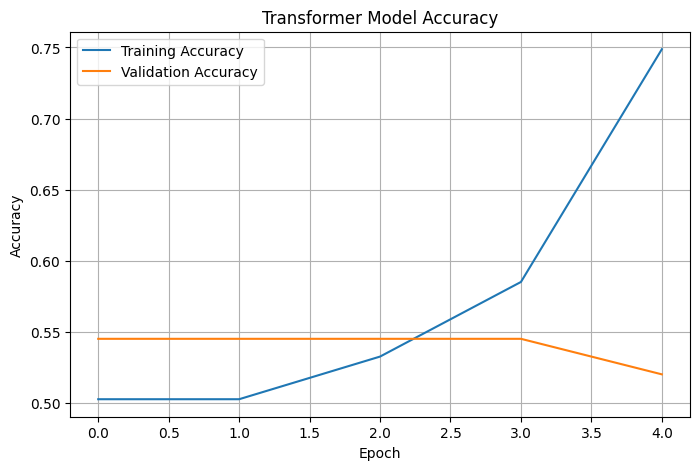

In [10]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

##  Step 9: Run Inference on a Custom Input

In [11]:
# Simulate a "positive" example with random token IDs
sample_input = np.random.randint(0, vocab_size, size=(1, sequence_length))

# Predict
pred = model.predict(sample_input)
predicted_class = np.argmax(pred, axis=1)[0]

# Display result
print(f"Predicted class: {predicted_class} | Probabilities: {pred[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Predicted class: 1 | Probabilities: [0.35023633 0.64976364]
